# AnoGAN

In [1]:
from model.dcgan import DCGAN
from model.anogan import AnoGAN

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
EPOCHS = 1000
NOISE_DIM = 100

IMAGE_SIZE = (64, 64)
CHANNELS = 3
IMAGE_SHAPE = IMAGE_SIZE + tuple([CHANNELS])

if CHANNELS == 1:
    color_mode = "grayscale"
else:
    color_mode = "rgb"

## Dataset

In [3]:
TRAIN_PATH = r"C:\Users\filip\Desktop\Universita\Laboratorio di Intelligenza Artificiale\hazelnut\train"
TEST_PATH = r"C:\Users\filip\Desktop\Universita\Laboratorio di Intelligenza Artificiale\hazelnut\test"

training_set = tf.keras.utils.image_dataset_from_directory(TRAIN_PATH, 
                                                           image_size = IMAGE_SIZE, 
                                                           color_mode = color_mode,
                                                           batch_size = None, 
                                                           shuffle = False)
test_set = tf.keras.utils.image_dataset_from_directory(TEST_PATH, 
                                                       image_size = IMAGE_SIZE, 
                                                       color_mode = color_mode,
                                                       batch_size = None,
                                                       shuffle = False)

Found 391 files belonging to 1 classes.
Found 110 files belonging to 5 classes.


### Normalizzazione

In [4]:
normalization_layer = tf.keras.layers.Rescaling(scale = (1./127.5), offset = -1)

normalized_training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
normalized_test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

In [5]:
BUFFER_SIZE = 391
BATCH_SIZE = 17
normalized_training_set = normalized_training_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## GAN

In [6]:
gan = DCGAN(IMAGE_SHAPE, NOISE_DIM)

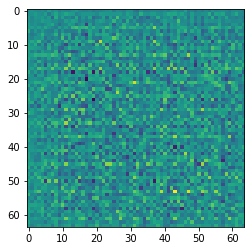

In [7]:
img = gan.generator(tf.random.normal([1,NOISE_DIM]))

plt.imshow(img[0, :, :, 0])
plt.show()

In [8]:
print(gan.discriminator(img))

tf.Tensor([[0.00013822]], shape=(1, 1), dtype=float32)


## Training

Epoch 1000   -   Generator Loss: 3.550	Discriminator Loss: 0.278	Time: 21.6s


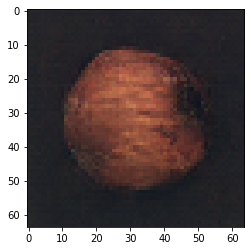

In [17]:
disc_loss, gen_loss = gan.train(normalized_training_set, EPOCHS)

In [9]:
gan.restore()

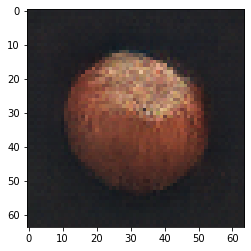

In [18]:
generated_image = gan.generator(tf.random.normal([1, NOISE_DIM]))
generated_image = np.array(generated_image[0] * 127.5 + 127.5, np.int32)
plt.imshow(generated_image, cmap="gray")
plt.show()

In [12]:
plt.plot(disc_loss, label = "d_loss")
plt.plot(gen_loss, label = "g_loss")
plt.show()

NameError: name 'disc_loss' is not defined

## Anomaly Detection

In [14]:
anogan = AnoGAN(gan)

In [15]:
test_image = []
for image, label in normalized_test_set:
    test_image = image.numpy()
    break
test_image = np.array([test_image])
anomaly_score, similar_img = anogan.anomaly_detection(test_image)

1/1 [==============================] - 0s 228ms/step


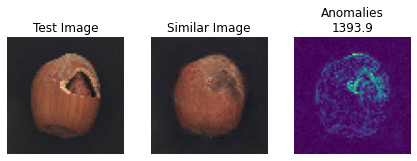

In [16]:
test_image = np.array((test_image[0] * 127.5) + 127.5, np.int32)
similar_image = np.array((similar_img[0] * 127.5) + 127.5, np.int32)

plt.figure(figsize = (15, 15))

plt.subplot(6, 6, 1)
plt.imshow(test_image)
plt.title("Test Image")
plt.axis("off")

plt.subplot(6, 6, 2)
plt.imshow(similar_image)
plt.title("Similar Image")
plt.axis("off")

plt.subplot(6, 6, 3)
plt.imshow(abs(similar_image - test_image)[:, :, 0])
plt.title("Anomalies\n{0:.1f}".format(anomaly_score))
plt.axis("off")

plt.show()

## Test

In [13]:
gan.generator.load_weights("weights/generator.h5")
gan.discriminator.load_weights("weights/discriminator.h5")

Test 110 / 110 Label: 4 	Anomaly Score: 1778.1181640625


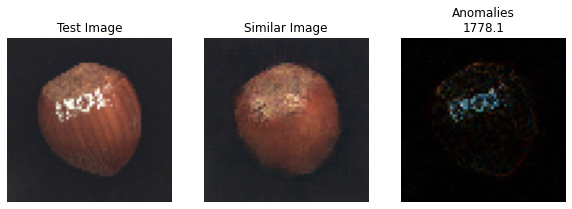

In [17]:
results, threshold, accuracy = anogan.test(normalized_test_set)

In [25]:
print("Accuracy: {0:.2f}%".format(accuracy*100))

Accuracy: 76.36%


In [26]:
print(threshold)

967.3617858886719
